In [1]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
import tensorflow as tf

In [3]:
import argparse

ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", type=str, help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, default="mask_detectorch.model", help="path to output face mask detector model")
args, unknown = ap.parse_known_args()

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 8
BS = 10

In [6]:
from imutils import paths

print("[INFO] loading images...")
imagePaths = list(paths.list_images(r"C:\AI COURSE TAMIL\artificial inteligence\mask\dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


C:\Users\MANIKA\Anaconda3\envs\mask\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [10]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


C:\Users\MANIKA\Anaconda3\envs\mask\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/8
307/307 [==============================] - 156s 489ms/step - loss: 0.2597 - accuracy: 0.9136 - val_loss: 0.0742 - val_accuracy: 0.9883
Epoch 2/8
307/307 [==============================] - 129s 421ms/step - loss: 0.0884 - accuracy: 0.9768 - val_loss: 0.0509 - val_accuracy: 0.9896
Epoch 3/8
307/307 [==============================] - 128s 416ms/step - loss: 0.0651 - accuracy: 0.9801 - val_loss: 0.0408 - val_accuracy: 0.9909
Epoch 4/8
307/307 [==============================] - 127s 414ms/step - loss: 0.0602 - accuracy: 0.9821 - val_loss: 0.0565 - val_accuracy: 0.9818
Epoch 5/8
307/307 [==============================] - 132s 430ms/step - loss: 0.0466 - accuracy: 0.9847 - val_loss: 0.0391 - val_accuracy: 0.9922
Epoch 6/8
307/307 [==============================] - 129s 421ms/step - loss: 0.0382 - accuracy: 0.9860 - val_loss: 0.0340 - val_accuracy: 0.9909
Epoch 7/8
307/307 [==============================] - 143s 467ms/step - loss: 0.0387 - accuracy: 0.9866 - v

In [15]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
77/77 [==============================] - 24s 294ms/step


In [16]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [17]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



In [18]:
# Set the desired argument values directly
args = argparse.Namespace(model="model.h5")

# The rest of your code...

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(args.model, save_format="h5")

[INFO] saving mask detector model...


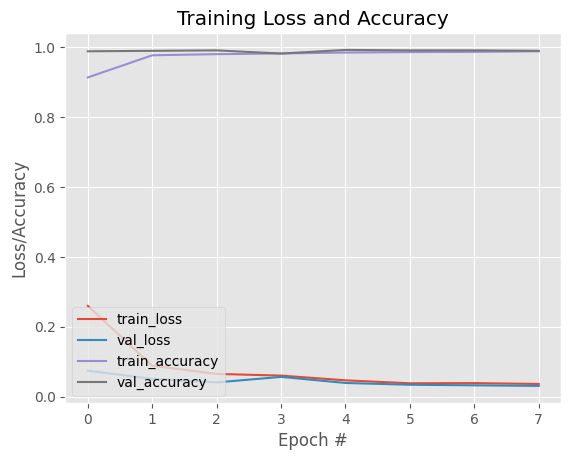

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")  # Modify this line
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")  # Modify this line
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [21]:
import matplotlib.pyplot as plt

# Load TensorBoard extension (if not already loaded)
%load_ext tensorboard

# Start TensorBoard (use the correct log_dir)
%tensorboard --logdir ./logs

# Load the data from TensorBoard logs
from tensorboard.backend.event_processing import event_accumulator

event_acc = event_accumulator.EventAccumulator('./logs')
event_acc.Reload()

# List available metrics
print(event_acc.Tags())

# Extract training and validation loss and accuracy
training_loss = event_acc.Scalars('train_loss')
validation_loss = event_acc.Scalars('val_loss')
training_accuracy = event_acc.Scalars('train_accuracy')
validation_accuracy = event_acc.Scalars('val_accuracy')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([scalar.step for scalar in training_loss], [scalar.value for scalar in training_loss], label='train_loss')
plt.plot([scalar.step for scalar in validation_loss], [scalar.value for scalar in validation_loss], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot([scalar.step for scalar in training_accuracy], [scalar.value for scalar in training_accuracy], label='train_accuracy')
plt.plot([scalar.step for scalar in validation_accuracy], [scalar.value for scalar in validation_accuracy], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9876), started 0:00:21 ago. (Use '!kill 9876' to kill it.)

DirectoryDeletedError: Directory ./logs has been permanently deleted